In [ ]:
# default_exp transforms

# Transforms

> Utilities to transform between a few of the many rotational formalisms.

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# imports that are only required for testing
import tempfile
import warnings
from itertools import permutations, chain
from llamass.core import unpack_body_models, AMASS

In [ ]:
# export
import torch
import torch.nn.functional as F
import numpy as np
from scipy.spatial.transform import Rotation as R

# Copied Code

This code is copied [from torchgeometry in `nghorbani/human_body_prior`][hbptools]. Copying it into this library to run tests with it.

[hbptools]: https://github.com/nghorbani/human_body_prior/blob/0278cb45180992e4d39ba1a11601f5ecc53ee148/src/human_body_prior/tools/tgm_conversion.py

In [ ]:
# exports
def rotation_matrix_to_angle_axis(rotation_matrix):
    """Convert 3x4 rotation matrix to Rodrigues vector
    Args:
        rotation_matrix (Tensor): rotation matrix.
    Returns:
        Tensor: Rodrigues vector transformation.
    Shape:
        - Input: :math:`(N, 3, 4)`
        - Output: :math:`(N, 3)`
    Example:
        >>> input = torch.rand(2, 3, 4)  # Nx4x4
        >>> output = tgm.rotation_matrix_to_angle_axis(input)  # Nx3
    """
    # todo add check that matrix is a valid rotation matrix
    quaternion = rotation_matrix_to_quaternion(rotation_matrix)
    return quaternion_to_angle_axis(quaternion)

def rotation_matrix_to_quaternion(rotation_matrix, eps=1e-6):
    """Convert 3x4 rotation matrix to 4d quaternion vector
    This algorithm is based on algorithm described in
    https://github.com/KieranWynn/pyquaternion/blob/master/pyquaternion/quaternion.py#L201
    Args:
        rotation_matrix (Tensor): the rotation matrix to convert.
    Return:
        Tensor: the rotation in quaternion
    Shape:
        - Input: :math:`(N, 3, 4)`
        - Output: :math:`(N, 4)`
    Example:
        >>> input = torch.rand(4, 3, 4)  # Nx3x4
        >>> output = tgm.rotation_matrix_to_quaternion(input)  # Nx4
    """
    if not torch.is_tensor(rotation_matrix):
        raise TypeError("Input type is not a torch.Tensor. Got {}".format(
            type(rotation_matrix)))

    if len(rotation_matrix.shape) > 3:
        raise ValueError(
            "Input size must be a three dimensional tensor. Got {}".format(
                rotation_matrix.shape))
    if not rotation_matrix.shape[-2:] == (3, 4):
        raise ValueError(
            "Input size must be a N x 3 x 4  tensor. Got {}".format(
                rotation_matrix.shape))

    rmat_t = torch.transpose(rotation_matrix, 1, 2)

    mask_d2 = rmat_t[:, 2, 2] < eps

    mask_d0_d1 = rmat_t[:, 0, 0] > rmat_t[:, 1, 1]
    mask_d0_nd1 = rmat_t[:, 0, 0] < -rmat_t[:, 1, 1]

    t0 = 1 + rmat_t[:, 0, 0] - rmat_t[:, 1, 1] - rmat_t[:, 2, 2]
    q0 = torch.stack([rmat_t[:, 1, 2] - rmat_t[:, 2, 1],
                      t0, rmat_t[:, 0, 1] + rmat_t[:, 1, 0],
                      rmat_t[:, 2, 0] + rmat_t[:, 0, 2]], -1)
    t0_rep = t0.repeat(4, 1).t()

    t1 = 1 - rmat_t[:, 0, 0] + rmat_t[:, 1, 1] - rmat_t[:, 2, 2]
    q1 = torch.stack([rmat_t[:, 2, 0] - rmat_t[:, 0, 2],
                      rmat_t[:, 0, 1] + rmat_t[:, 1, 0],
                      t1, rmat_t[:, 1, 2] + rmat_t[:, 2, 1]], -1)
    t1_rep = t1.repeat(4, 1).t()

    t2 = 1 - rmat_t[:, 0, 0] - rmat_t[:, 1, 1] + rmat_t[:, 2, 2]
    q2 = torch.stack([rmat_t[:, 0, 1] - rmat_t[:, 1, 0],
                      rmat_t[:, 2, 0] + rmat_t[:, 0, 2],
                      rmat_t[:, 1, 2] + rmat_t[:, 2, 1], t2], -1)
    t2_rep = t2.repeat(4, 1).t()

    t3 = 1 + rmat_t[:, 0, 0] + rmat_t[:, 1, 1] + rmat_t[:, 2, 2]
    q3 = torch.stack([t3, rmat_t[:, 1, 2] - rmat_t[:, 2, 1],
                      rmat_t[:, 2, 0] - rmat_t[:, 0, 2],
                      rmat_t[:, 0, 1] - rmat_t[:, 1, 0]], -1)
    t3_rep = t3.repeat(4, 1).t()

    mask_c0 = mask_d2 * mask_d0_d1
    mask_c1 = mask_d2 * torch.logical_not(mask_d0_d1)
    mask_c2 = torch.logical_not(mask_d2) * mask_d0_nd1
    mask_c3 = torch.logical_not(mask_d2) * torch.logical_not(mask_d0_nd1)
    mask_c0 = mask_c0.view(-1, 1).type_as(q0)
    mask_c1 = mask_c1.view(-1, 1).type_as(q1)
    mask_c2 = mask_c2.view(-1, 1).type_as(q2)
    mask_c3 = mask_c3.view(-1, 1).type_as(q3)

    q = q0 * mask_c0 + q1 * mask_c1 + q2 * mask_c2 + q3 * mask_c3
    q /= torch.sqrt(t0_rep * mask_c0 + t1_rep * mask_c1 +  # noqa
                    t2_rep * mask_c2 + t3_rep * mask_c3)  # noqa
    q *= 0.5
    return q

def quaternion_to_angle_axis(quaternion) -> torch.Tensor:
    """Convert quaternion vector to angle axis of rotation.
    Adapted from ceres C++ library: ceres-solver/include/ceres/rotation.h
    Args:
        quaternion (torch.Tensor): tensor with quaternions.
    Return:
        torch.Tensor: tensor with angle axis of rotation.
    Shape:
        - Input: :math:`(*, 4)` where `*` means, any number of dimensions
        - Output: :math:`(*, 3)`
    Example:
        >>> quaternion = torch.rand(2, 4)  # Nx4
        >>> angle_axis = tgm.quaternion_to_angle_axis(quaternion)  # Nx3
    """
    if not torch.is_tensor(quaternion):
        raise TypeError("Input type is not a torch.Tensor. Got {}".format(
            type(quaternion)))

    if not quaternion.shape[-1] == 4:
        raise ValueError("Input must be a tensor of shape Nx4 or 4. Got {}"
                         .format(quaternion.shape))
    # unpack input and compute conversion
    q1 = quaternion[..., 1]
    q2 = quaternion[..., 2]
    q3 = quaternion[..., 3]
    sin_squared_theta = q1 * q1 + q2 * q2 + q3 * q3

    sin_theta = torch.sqrt(sin_squared_theta)
    cos_theta = quaternion[..., 0]
    two_theta = 2.0 * torch.where(
        cos_theta < 0.0,
        torch.atan2(-sin_theta, -cos_theta),
        torch.atan2(sin_theta, cos_theta))

    k_pos = two_theta / sin_theta
    k_neg = 2.0 * torch.ones_like(sin_theta)
    k = torch.where(sin_squared_theta > 0.0, k_pos, k_neg)

    angle_axis = torch.zeros_like(quaternion)[..., :3]
    angle_axis[..., 0] += q1 * k
    angle_axis[..., 1] += q2 * k
    angle_axis[..., 2] += q3 * k
    return angle_axis

def angle_axis_to_rotation_matrix(angle_axis):
    """Convert 3d vector of axis-angle rotation to 4x4 rotation matrix
    Args:
        angle_axis (Tensor): tensor of 3d vector of axis-angle rotations.
    Returns:
        Tensor: tensor of 4x4 rotation matrices.
    Shape:
        - Input: :math:`(N, 3)`
        - Output: :math:`(N, 4, 4)`
    Example:
        >>> input = torch.rand(1, 3)  # Nx3
        >>> output = tgm.angle_axis_to_rotation_matrix(input)  # Nx4x4
    """
    def _compute_rotation_matrix(angle_axis, theta2, eps=1e-6):
        # We want to be careful to only evaluate the square root if the
        # norm of the angle_axis vector is greater than zero. Otherwise
        # we get a division by zero.
        k_one = 1.0
        theta = torch.sqrt(torch.clamp(theta2, eps, 1e4))
        wxyz = angle_axis / (theta + eps)
        wx, wy, wz = torch.chunk(wxyz, 3, dim=1)
        cos_theta = torch.cos(theta)
        sin_theta = torch.sin(theta)

        r00 = cos_theta + wx * wx * (k_one - cos_theta)
        r10 = wz * sin_theta + wx * wy * (k_one - cos_theta)
        r20 = -wy * sin_theta + wx * wz * (k_one - cos_theta)
        r01 = wx * wy * (k_one - cos_theta) - wz * sin_theta
        r11 = cos_theta + wy * wy * (k_one - cos_theta)
        r21 = wx * sin_theta + wy * wz * (k_one - cos_theta)
        r02 = wy * sin_theta + wx * wz * (k_one - cos_theta)
        r12 = -wx * sin_theta + wy * wz * (k_one - cos_theta)
        r22 = cos_theta + wz * wz * (k_one - cos_theta)
        rotation_matrix = torch.cat(
            [r00, r01, r02, r10, r11, r12, r20, r21, r22], dim=1)
        return rotation_matrix.view(-1, 3, 3)

    def _compute_rotation_matrix_taylor(angle_axis):
        rx, ry, rz = torch.chunk(angle_axis, 3, dim=1)
        k_one = torch.ones_like(rx)
        rotation_matrix = torch.cat(
            [k_one, -rz, ry, rz, k_one, -rx, -ry, rx, k_one], dim=1)
        return rotation_matrix.view(-1, 3, 3)

    # stolen from ceres/rotation.h

    _angle_axis = torch.unsqueeze(angle_axis, dim=1)
    theta2 = torch.matmul(_angle_axis, _angle_axis.transpose(1, 2))
    theta2 = torch.squeeze(theta2, dim=1)

    # compute rotation matrices
    rotation_matrix_normal = _compute_rotation_matrix(angle_axis, theta2)
    rotation_matrix_taylor = _compute_rotation_matrix_taylor(angle_axis)

    # create mask to handle both cases
    eps = 1e-6
    mask = (theta2 > eps).view(-1, 1, 1).to(theta2.device)
    mask_pos = (mask).type_as(theta2)
    mask_neg = (mask == False).type_as(theta2)  # noqa

    # create output pose matrix
    batch_size = angle_axis.shape[0]
    rotation_matrix = torch.eye(4).to(angle_axis.device).type_as(angle_axis)
    rotation_matrix = rotation_matrix.view(1, 4, 4).repeat(batch_size, 1, 1)
    # fill output matrix with masked values
    rotation_matrix[..., :3, :3] = \
        mask_pos * rotation_matrix_normal + mask_neg * rotation_matrix_taylor
    return rotation_matrix  # Nx4x4

In [ ]:
# human_body_prior
# this cell tests that the above copied code is consistent with the code in the original library
import human_body_prior.tools.rotation_tools as hbp_rot

def matrot2aa(pose_matrot):
    '''
    :param pose_matrot: Nx3x3
    :return: Nx3
    '''
    bs = pose_matrot.size(0)
    homogen_matrot = F.pad(pose_matrot, [0,1])
    pose = rotation_matrix_to_angle_axis(homogen_matrot)
    return pose

def aa2matrot(pose):
    '''
    :param Nx3
    :return: pose_matrot: Nx3x3
    '''
    bs = pose.size(0)
    num_joints = pose.size(1)//3
    pose_body_matrot = angle_axis_to_rotation_matrix(pose)[:, :3, :3].contiguous()
    return pose_body_matrot

with tempfile.TemporaryDirectory() as tmpdirname:
    unpack_body_models("sample_data/", tmpdirname, 2)
    amass = AMASS(tmpdirname, overlapping=False, clip_length=1, transform=torch.tensor)
    poses = []
    for x in amass:
        pose = x['poses'][:,3:66]
        poses.append(pose)
    poses = torch.stack(poses).view(-1, 3)
    m = aa2matrot(poses)
    _m = hbp_rot.aa2matrot(poses)
    assert torch.abs(m - _m).max() < 1e-4

  0%|          | 0/1 [00:00<?, ?it/s]

# Rotation Class

> A `scipy.spatial.transform`-like interface to transform Tensors.

In [ ]:
# exports
class Rotation():
    """
    Class to give a scipy.spatial.transform-like interface
    for converting between rotational formalisms in PyTorch.
    Acts on trailing axes and maintains leading tensor shape.
    """
    def __init__(self, tensor, shape, formalism):
        self.tensor, self.shape = tensor, shape
        self.formalism = formalism
    
    @staticmethod
    def from_rotvec(x):
        return Rotation(x.view(-1, 3), x.size(), 'rotvec')
        
    @staticmethod
    def from_matrix(x):
        return Rotation(x.view(-1, 3, 3), x.size(), 'matrix')
    
    def as_rotvec(self):
        if self.formalism != 'matrix':
            raise NotImplementedError()
        s = self.shape
        rotvec = rotation_matrix_to_angle_axis(F.pad(self.tensor, [0,1]))
        return rotvec.reshape(*s[:-1], s[-1]//3)
    
    def as_matrix(self):
        if self.formalism != 'rotvec':
            raise NotImplementedError()
        s = self.shape
        matrot = angle_axis_to_rotation_matrix(self.tensor)[:, :3, :3].contiguous()
        return matrot.view(*s[:-1], s[-1]*3)

    def from_euler(self):
        raise NotImplementedError()
    def from_quat(self):
        raise NotImplementedError()
    def from_mrp(self):
        raise NotImplementedError()
    def as_euler(self, degrees=False):
        if degrees:
            raise NotImplementedError("Degrees as output not supported.")
        if self.formalism == 'rotvec':
            self = Rotation.from_matrix(self.as_matrix())
        elif self.formalism != 'matrix':
            raise NotImplementedError()
        rs = self.tensor
        n_samples = rs.size(0)
        
        # initialize to zeros
        e1 = torch.zeros([n_samples]).to(rs.device)
        e2 = torch.zeros([n_samples]).to(rs.device)
        e3 = torch.zeros([n_samples]).to(rs.device)
        
        # find indices where we need to treat special cases
        is_one = rs[:, 0, 2] == 1
        is_minus_one = rs[:, 0, 2] == -1
        is_special = torch.logical_or(is_one, is_minus_one)
        
        e1[is_special] = torch.atan2(rs[is_special, 0, 1], rs[is_special, 0, 2])
        e2[is_minus_one] = np.pi/2
        e2[is_one] = -np.pi/2
        
        # normal cases
        is_normal = torch.logical_not(torch.logical_or(is_one, is_minus_one))
        # clip inputs to arcsin
        in_ = torch.clamp(rs[is_normal, 0, 2], -1, 1)
        e2[is_normal] = -torch.arcsin(in_)
        e2_cos = torch.cos(e2[is_normal])
        e1[is_normal] = torch.atan2(rs[is_normal, 1, 2]/e2_cos,
                                    rs[is_normal, 2, 2]/e2_cos)
        e3[is_normal] = torch.atan2(rs[is_normal, 0, 1]/e2_cos,
                                    rs[is_normal, 0, 0]/e2_cos)

        eul = torch.stack([e1, e2, e3], axis=-1)
        #eul = np.reshape(eul, np.concatenate([orig_shape, eul.shape[1:]]))
        s = self.shape
        eul = eul.reshape(*s[:-1], s[-1]//3)
        return eul
    def as_quat(self):
        raise NotImplementedError()
    def as_mrp(self):
        raise NotImplementedError()

The following cell tests that the baked in `aa2matrot` function computes the same rotation matrices as scipy. It also confirms that the data is definitely encoded as rotation vectors.

In [ ]:
"""
MIT License

Copyright (c) 2016 Julieta Martinez, Javier Romero

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

def rotmat2euler( R ):
    """
    Converts a rotation matrix to Euler angles
    Matlab port to python for evaluation purposes
    https://github.com/asheshjain399/RNNexp/blob/srnn/structural_rnn/CRFProblems/H3.6m/mhmublv/Motion/RotMat2Euler.m#L1
    Args
    R: a 3x3 rotation matrix
    Returns
    eul: a 3x1 Euler angle representation of R
    """
    if R[0,2] == 1 or R[0,2] == -1:
        # special case
        E3   = 0 # set arbitrarily
        dlta = np.arctan2( R[0,1], R[0,2] );

        if R[0,2] == -1:
            E2 = np.pi/2;
            E1 = E3 + dlta;
        else:
            E2 = -np.pi/2;
            E1 = -E3 + dlta;
    else:
        E2 = -np.arcsin( R[0,2] )
        E1 = np.arctan2( R[1,2]/np.cos(E2), R[2,2]/np.cos(E2) )
        E3 = np.arctan2( R[0,1]/np.cos(E2), R[0,0]/np.cos(E2) )

    eul = np.array([E1, E2, E3]);
    return eul

In [ ]:
with tempfile.TemporaryDirectory() as tmpdirname:
    unpack_body_models("sample_data/", tmpdirname, 2)
    amass = AMASS(tmpdirname, overlapping=False, clip_length=1, transform=torch.tensor)
    poses = []
    for x in amass:
        pose = x['poses'][:,3:66]
        poses.append(pose)
    poses = torch.stack(poses)
    
    # test rotvec -> matrix
    m = Rotation.from_rotvec(poses).as_matrix()
    # check if this match scipy
    matrots = []
    for rotvec in poses.view(-1, 3):
        r = R.from_rotvec(rotvec.numpy())
        matrots.append(r.as_matrix())
    matrots = torch.tensor(np.stack(matrots))
    assert torch.abs(matrots - m.view(-1, 3, 3)).max() < 1e-5
    
    # test matrix -> rotvec
    aa = Rotation.from_matrix(m).as_rotvec()
    rotvecs = []
    for matrix in m.view(-1, 3*3):
        r = R.from_matrix(matrix.view(3, 3))
        rotvecs.append(r.as_rotvec())
    rotvecs = torch.tensor(np.stack(rotvecs))
    assert torch.abs(rotvecs - aa.view(-1, 3)).max() < 1e-5
    assert torch.abs(poses - aa).max() < 1e-5
    
    # test rotvec -> matrix -> euler
    e = Rotation.from_rotvec(poses).as_euler()
    # iterate over all possible euler angle conventions
    for seq in chain(permutations('xyz'), permutations('XYZ')):
        euler_angles = []
        for rotvec in poses.view(-1, 3):
            r = R.from_rotvec(rotvec.numpy())
            euler_angles.append(r.as_euler("".join(seq), degrees=False))
        euler_angles = torch.tensor(np.stack(euler_angles))
        err = torch.abs(euler_angles - e.view(-1, 3)).max()
        #print(seq, *[x.item() for x in [err, e.min(), e.max(), euler_angles.min(), euler_angles.max()]])
        if err < 1e-5:
            break
    if err > 1e-5:
        warnings.warn(f"Euler angle computation does not match any convention.")
    euler_angles = []
    for rotmat in matrots:
        euler_angles.append(rotmat2euler(rotmat.numpy()))
    euler_angles = torch.tensor(np.stack(euler_angles))
    err = torch.abs(euler_angles - e.view(-1, 3)).max()
    assert err < 1e-5

  0%|          | 0/1 [00:00<?, ?it/s]

/nobackup/gngdb/envs/amass/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Euler angle computation does not match any convention.


In [ ]:
r = matrots[0].numpy()
e = rotmat2euler(r)
for seq in chain(permutations('xyz'), permutations('XYZ')):
    seq = "".join(seq)
    _e = R.from_matrix(r).as_euler(seq, degrees=False)
    print(seq, e-_e)

xyz [ 1.54809437  0.31419901 -0.26214211]
xzy [1.52761688 0.01639201 0.03872136]
yxz [ 0.91142335  0.98763906 -0.15936584]
yzx [0.97618798 0.14463208 0.71229793]
zxy [0.50030164 0.95476593 0.22065227]
zyx [0.69825729 0.42061958 0.69825729]
XYZ [ 1.53083387  0.42061958 -0.13431928]
XZY [1.5448745  0.14463208 0.1436114 ]
YXZ [ 1.05322884  0.95476593 -0.33227493]
YZX [0.87129794 0.01639201 0.6950403 ]
ZXY [0.67321073 0.98763906 0.07884678]
ZYX [0.57043446 0.31419901 0.7155178 ]


# Forward Kinematics

> Checking forward kinematics match SPL's implementation

To do:

* ~~Create SMPLH forward kinematics engine based on SPL's SMPL forward kinematics engine~~
* ~~Use this to produce joint positions and visualize them~~
* ~~Verify that they're the same poses as produced by MPI's body model~~
* ~~Create nn.Module that produces the same output~~
* Use nn.Module to process and visualize data from sample data, verify that it produces valid poses

## SPL Reference Code

> Reference implementation from SPL paper.

In [ ]:
# spl
# I don't want to install tensorflow to install their whole package for testing
!git clone https://github.com/eth-ait/spl.git 2>/dev/null
import sys
from pathlib import Path
common_path = "./spl/common"
if common_path not in sys.path:
    sys.path.append(common_path)
from conversions import (is_valid_rotmat, rotmat2euler, aa2rotmat, get_closest_rotmat, sparse_to_full, local_rot_to_global)
import cv2

/nobackup/gngdb/envs/amass/lib/python3.7/site-packages/quaternion/numba_wrapper.py:23: UserWarning: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Could not import from numba, which means that some
parts of this code may run MUCH more slowly.  You
may wish to install numba.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  warnings.warn(warning_text)


In [ ]:
# spl
# %load ./spl/visualization/fk.py
"""
SPL: training and evaluation of neural networks with a structured prediction layer.
Copyright (C) 2019 ETH Zurich, Emre Aksan, Manuel Kaufmann

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.
"""
import numpy as np
import quaternion
import cv2

#from common.conversions import sparse_to_full

# This comes from Martinez' preprocessing, does not take into account root position.
H36M_JOINTS_TO_IGNORE = [5, 10, 15, 20, 21, 22, 23, 28, 29, 30, 31]
H36M_MAJOR_JOINTS = [0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 24, 25, 26, 27]
H36M_NR_JOINTS = 32
H36M_PARENTS = [-1, 0, 1, 2, 3, 4, 0, 6, 7, 8, 9, 0, 11, 12, 13, 14, 12,
                16, 17, 18, 19, 20, 19, 22, 12, 24, 25, 26, 27, 28, 27, 30]

SMPL_MAJOR_JOINTS = [1, 2, 3, 4, 5, 6, 9, 12, 13, 14, 15, 16, 17, 18, 19]
SMPL_NR_JOINTS = 24
SMPL_PARENTS = [-1, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21]
SMPL_JOINTS = ['pelvis', 'l_hip', 'r_hip', 'spine1', 'l_knee', 'r_knee', 'spine2', 'l_ankle', 'r_ankle', 'spine3',
               'l_foot', 'r_foot', 'neck', 'l_collar', 'r_collar', 'head', 'l_shoulder', 'r_shoulder',
               'l_elbow', 'r_elbow', 'l_wrist', 'r_wrist', 'l_hand', 'r_hand']
SMPL_JOINT_MAPPING = {i: x for i, x in enumerate(SMPL_JOINTS)}


class _ForwardKinematics(object):
    """
    FK Engine.
    """
    def __init__(self, offsets, parents, left_mult=False, major_joints=None, norm_idx=None, no_root=True):
        self.offsets = offsets
        if norm_idx is not None:
            self.offsets = self.offsets / np.linalg.norm(self.offsets[norm_idx])
        self.parents = parents
        self.n_joints = len(parents)
        self.major_joints = major_joints
        self.left_mult = left_mult
        self.no_root = no_root
        assert self.offsets.shape[0] == self.n_joints

    def fk(self, joint_angles):
        """
        Perform forward kinematics. This requires joint angles to be in rotation matrix format.
        Args:
            joint_angles: np array of shape (N, n_joints*3*3)

        Returns:
            The 3D joint positions as a an array of shape (N, n_joints, 3)
        """
        assert joint_angles.shape[-1] == self.n_joints * 9
        angles = np.reshape(joint_angles, [-1, self.n_joints, 3, 3])
        n_frames = angles.shape[0]
        positions = np.zeros([n_frames, self.n_joints, 3])
        rotations = np.zeros([n_frames, self.n_joints, 3, 3])  # intermediate storage of global rotation matrices
        if self.left_mult:
            offsets = self.offsets[np.newaxis, np.newaxis, ...]  # (1, 1, n_joints, 3)
        else:
            offsets = self.offsets[np.newaxis, ..., np.newaxis]  # (1, n_joints, 3, 1)

        if self.no_root:
            angles[:, 0] = np.eye(3)

        for j in range(self.n_joints):
            if self.parents[j] == -1:
                # this is the root, we don't consider any root translation
                positions[:, j] = 0.0
                rotations[:, j] = angles[:, j]
            else:
                # this is a regular joint
                if self.left_mult:
                    positions[:, j] = np.squeeze(np.matmul(offsets[:, :, j], rotations[:, self.parents[j]])) + \
                                      positions[:, self.parents[j]]
                    rotations[:, j] = np.matmul(angles[:, j], rotations[:, self.parents[j]])
                else:
                    positions[:, j] = np.squeeze(np.matmul(rotations[:, self.parents[j]], offsets[:, j])) + \
                                      positions[:, self.parents[j]]
                    rotations[:, j] = np.matmul(rotations[:, self.parents[j]], angles[:, j])

        return positions

    def from_aa(self, joint_angles):
        """
        Get joint positions from angle axis representations in shape (N, n_joints*3).
        """
        angles = np.reshape(joint_angles, [-1, self.n_joints, 3])
        angles_rot = np.zeros(angles.shape + (3,))
        for i in range(angles.shape[0]):
            for j in range(self.n_joints):
                angles_rot[i, j] = cv2.Rodrigues(angles[i, j])[0]
        return self.fk(np.reshape(angles_rot, [-1, self.n_joints * 9]))

    def from_rotmat(self, joint_angles):
        """
        Get joint positions from rotation matrix representations in shape (N, H36M_NR_JOINTS*3*3).
        """
        return self.fk(joint_angles)

    def from_quat(self, joint_angles):
        """
        Get joint positions from quaternion representations in shape (N, H36M_NR_JOINTS*4)
        """
        qs = quaternion.from_float_array(np.reshape(joint_angles, [-1, H36M_NR_JOINTS, 4]))
        aa = quaternion.as_rotation_matrix(qs)
        return self.fk(np.reshape(aa, [-1, H36M_NR_JOINTS * 3]))

    def from_sparse(self, joint_angles_sparse, rep="rotmat", return_sparse=True):
        """
        Get joint positions from reduced set of H36M joints.
        Args:
            joint_angles_sparse: np array of shape (N, len(sparse_joint_idxs) * dof))
            sparse_joints_idxs: List of indices into `H36M_JOINTS` pointing out which SMPL joints are used in
              `pose_sparse`. If None defaults to `H36M_MAJOR_JOINTS`.
            rep: "rotmat" or "quat", which representation is used for the angles in `joint_angles_sparse`
            return_sparse: If True it will return only the positions of the joints given in `sparse_joint_idxs`.

        Returns:
            The joint positions as an array of shape (N, len(sparse_joint_idxs), 3) if `return_sparse` is True
            otherwise (N, H36M_NR_JOINTS, 3).
        """
        assert self.major_joints is not None
        assert rep in ["rotmat", "quat", "aa"]
        joint_angles_full = sparse_to_full(joint_angles_sparse, self.major_joints, self.n_joints, rep)
        fk_func = self.from_quat if rep == "quat" else self.from_aa if rep == "aa" else self.from_rotmat
        positions = fk_func(joint_angles_full)
        if return_sparse:
            positions = positions[:, self.major_joints]
        return positions


class H36M_ForwardKinematics(_ForwardKinematics):
    """
    Forward Kinematics for the skeleton defined by H3.6M dataset.
    """
    def __init__(self):
        offsets = np.array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
                            [-1.32948591e+02, 0.00000000e+00, 0.00000000e+00],
                            [0.00000000e+00, -4.42894612e+02, 0.00000000e+00],
                            [0.00000000e+00, -4.54206447e+02, 0.00000000e+00],
                            [0.00000000e+00, 0.00000000e+00, 1.62767078e+02],
                            [0.00000000e+00, 0.00000000e+00, 7.49994370e+01],
                            [1.32948826e+02, 0.00000000e+00, 0.00000000e+00],
                            [0.00000000e+00, -4.42894413e+02, 0.00000000e+00],
                            [0.00000000e+00, -4.54206590e+02, 0.00000000e+00],
                            [0.00000000e+00, 0.00000000e+00, 1.62767426e+02],
                            [0.00000000e+00, 0.00000000e+00, 7.49999480e+01],
                            [0.00000000e+00, 1.00000000e-01, 0.00000000e+00],
                            [0.00000000e+00, 2.33383263e+02, 0.00000000e+00],
                            [0.00000000e+00, 2.57077681e+02, 0.00000000e+00],
                            [0.00000000e+00, 1.21134938e+02, 0.00000000e+00],
                            [0.00000000e+00, 1.15002227e+02, 0.00000000e+00],
                            [0.00000000e+00, 2.57077681e+02, 0.00000000e+00],
                            [0.00000000e+00, 1.51034226e+02, 0.00000000e+00],
                            [0.00000000e+00, 2.78882773e+02, 0.00000000e+00],
                            [0.00000000e+00, 2.51733451e+02, 0.00000000e+00],
                            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
                            [0.00000000e+00, 0.00000000e+00, 9.99996270e+01],
                            [0.00000000e+00, 1.00000188e+02, 0.00000000e+00],
                            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
                            [0.00000000e+00, 2.57077681e+02, 0.00000000e+00],
                            [0.00000000e+00, 1.51031437e+02, 0.00000000e+00],
                            [0.00000000e+00, 2.78892924e+02, 0.00000000e+00],
                            [0.00000000e+00, 2.51728680e+02, 0.00000000e+00],
                            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
                            [0.00000000e+00, 0.00000000e+00, 9.99998880e+01],
                            [0.00000000e+00, 1.37499922e+02, 0.00000000e+00],
                            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

        # normalize so that right thigh has length 1
        super(H36M_ForwardKinematics, self).__init__(offsets, H36M_PARENTS, norm_idx=7,
                                                    left_mult=True, major_joints=H36M_MAJOR_JOINTS)


class SMPL_ForwardKinematics(_ForwardKinematics):
    """
    Forward Kinematics for the skeleton defined by SMPL.
    """
    def __init__(self):
        # this are the offsets stored under `J` in the SMPL model pickle file
        offsets = np.array([[-8.76308970e-04, -2.11418723e-01, 2.78211200e-02],
                            [7.04848876e-02, -3.01002533e-01, 1.97749280e-02],
                            [-6.98883278e-02, -3.00379160e-01, 2.30254335e-02],
                            [-3.38451650e-03, -1.08161861e-01, 5.63597909e-03],
                            [1.01153808e-01, -6.65211904e-01, 1.30860155e-02],
                            [-1.06040718e-01, -6.71029623e-01, 1.38401121e-02],
                            [1.96440985e-04, 1.94957852e-02, 3.92296547e-03],
                            [8.95999143e-02, -1.04856032e+00, -3.04155922e-02],
                            [-9.20120818e-02, -1.05466743e+00, -2.80514913e-02],
                            [2.22362284e-03, 6.85680141e-02, 3.17901760e-02],
                            [1.12937580e-01, -1.10320516e+00, 8.39545265e-02],
                            [-1.14055299e-01, -1.10107698e+00, 8.98482216e-02],
                            [2.60992373e-04, 2.76811197e-01, -1.79753042e-02],
                            [7.75218998e-02, 1.86348444e-01, -5.08464100e-03],
                            [-7.48091986e-02, 1.84174211e-01, -1.00204779e-02],
                            [3.77815350e-03, 3.39133394e-01, 3.22299558e-02],
                            [1.62839013e-01, 2.18087461e-01, -1.23774789e-02],
                            [-1.64012068e-01, 2.16959041e-01, -1.98226746e-02],
                            [4.14086325e-01, 2.06120683e-01, -3.98959248e-02],
                            [-4.10001734e-01, 2.03806676e-01, -3.99843890e-02],
                            [6.52105424e-01, 2.15127546e-01, -3.98521818e-02],
                            [-6.55178550e-01, 2.12428626e-01, -4.35159074e-02],
                            [7.31773168e-01, 2.05445019e-01, -5.30577698e-02],
                            [-7.35578759e-01, 2.05180646e-01, -5.39352281e-02]])

        # need to convert them to compatible offsets
        smpl_offsets = np.zeros([24, 3])
        smpl_offsets[0] = offsets[0]
        for idx, pid in enumerate(SMPL_PARENTS[1:]):
            smpl_offsets[idx+1] = offsets[idx + 1] - offsets[pid]

        # normalize so that right thigh has length 1
        super(SMPL_ForwardKinematics, self).__init__(smpl_offsets, SMPL_PARENTS, norm_idx=4,
                                                    left_mult=False, major_joints=SMPL_MAJOR_JOINTS)

In [ ]:
# spl
from llamass.core import unpack_body_models, npz_paths
import tempfile
import warnings
import gaitplotlib.core as gpl
# body_model = gpl.init_body_model("neutral")

In [ ]:
# spl
subject_gender = 'neutral'
bm_fname = Path.home() / f".config/gaitplotlib/SMPLH_{subject_gender.upper()}.npz"
smplh = np.load(bm_fname)
print(len(SMPL_PARENTS))
SMPLH_PARENTS = [-1] + list(smplh['kintree_table'][0][1:24])

24


In [ ]:
# spl
for a,b in zip(SMPL_PARENTS, SMPLH_PARENTS):
    print(a, b)

-1 -1
0 0
0 0
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
9 9
9 9
12 12
13 13
14 14
16 16
17 17
18 18
19 19
20 20
21 22


In [ ]:
# spl
smplh['J']

array([[-1.79505953e-03, -2.23333446e-01,  2.82191255e-02],
       [ 6.77246757e-02, -3.14739671e-01,  2.14037877e-02],
       [-6.94655406e-02, -3.13855126e-01,  2.38993038e-02],
       [-4.32792313e-03, -1.14370215e-01,  1.52281192e-03],
       [ 1.02001221e-01, -6.89938274e-01,  1.69079858e-02],
       [-1.07755594e-01, -6.96424140e-01,  1.50492738e-02],
       [ 1.15910534e-03,  2.08102144e-02,  2.61528404e-03],
       [ 8.84055199e-02, -1.08789863e+00, -2.67853442e-02],
       [-9.19818258e-02, -1.09483879e+00, -2.72625243e-02],
       [ 2.61610388e-03,  7.37324481e-02,  2.80398521e-02],
       [ 1.14763659e-01, -1.14368952e+00,  9.25030544e-02],
       [-1.17353574e-01, -1.14298274e+00,  9.60854266e-02],
       [-1.62284535e-04,  2.87602804e-01, -1.48171829e-02],
       [ 8.14608431e-02,  1.95481750e-01, -6.04975478e-03],
       [-7.91430834e-02,  1.92565283e-01, -1.05754332e-02],
       [ 4.98955543e-03,  3.52572414e-01,  3.65317875e-02],
       [ 1.72437770e-01,  2.25950646e-01

In [ ]:
# spl
SMPLH_JOINT_NAMES = [
    'pelvis',
    'left_hip',
    'right_hip',
    'spine1',
    'left_knee',
    'right_knee',
    'spine2',
    'left_ankle',
    'right_ankle',
    'spine3',
    'left_foot',
    'right_foot',
    'neck',
    'left_collar',
    'right_collar',
    'head',
    'left_shoulder',
    'right_shoulder',
    'left_elbow',
    'right_elbow',
    'left_wrist',
    'right_wrist']

In [ ]:
# spl
print(len(SMPL_JOINTS), len(SMPLH_JOINT_NAMES))
for a, b in zip(SMPL_JOINTS, SMPLH_JOINT_NAMES):
    print(a, b)

24 22
pelvis pelvis
l_hip left_hip
r_hip right_hip
spine1 spine1
l_knee left_knee
r_knee right_knee
spine2 spine2
l_ankle left_ankle
r_ankle right_ankle
spine3 spine3
l_foot left_foot
r_foot right_foot
neck neck
l_collar left_collar
r_collar right_collar
head head
l_shoulder left_shoulder
r_shoulder right_shoulder
l_elbow left_elbow
r_elbow right_elbow
l_wrist left_wrist
r_wrist right_wrist


In [ ]:
# spl
SMPLH_PARENTS = [-1, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 12, 13, 14, 16, 17, 18, 19, 20, 22]
SMPLH_MAJOR_JOINTS = [1, 2, 3, 4, 5, 6, 9, 12, 13, 14, 15, 16, 17, 18, 19]

class _SMPLH_ForwardKinematics(_ForwardKinematics):
    """
    Forward Kinematics for the skeleton defined by SMPL-H.
    """
    def __init__(self):
        # this are the offsets stored under `J` in the SMPL model pickle file
        offsets = np.array([[-1.79505953e-03, -2.23333446e-01,  2.82191255e-02],
                           [ 6.77246757e-02, -3.14739671e-01,  2.14037877e-02],
                           [-6.94655406e-02, -3.13855126e-01,  2.38993038e-02],
                           [-4.32792313e-03, -1.14370215e-01,  1.52281192e-03],
                           [ 1.02001221e-01, -6.89938274e-01,  1.69079858e-02],
                           [-1.07755594e-01, -6.96424140e-01,  1.50492738e-02],
                           [ 1.15910534e-03,  2.08102144e-02,  2.61528404e-03],
                           [ 8.84055199e-02, -1.08789863e+00, -2.67853442e-02],
                           [-9.19818258e-02, -1.09483879e+00, -2.72625243e-02],
                           [ 2.61610388e-03,  7.37324481e-02,  2.80398521e-02],
                           [ 1.14763659e-01, -1.14368952e+00,  9.25030544e-02],
                           [-1.17353574e-01, -1.14298274e+00,  9.60854266e-02],
                           [-1.62284535e-04,  2.87602804e-01, -1.48171829e-02],
                           [ 8.14608431e-02,  1.95481750e-01, -6.04975478e-03],
                           [-7.91430834e-02,  1.92565283e-01, -1.05754332e-02],
                           [ 4.98955543e-03,  3.52572414e-01,  3.65317875e-02],
                           [ 1.72437770e-01,  2.25950646e-01, -1.49179062e-02],
                           [-1.75155461e-01,  2.25116450e-01, -1.97185045e-02],
                           [ 4.32050017e-01,  2.13178586e-01, -4.23743412e-02],
                           [-4.28897421e-01,  2.11787231e-01, -4.11194829e-02],
                           [ 6.81283645e-01,  2.22164620e-01, -4.35452575e-02],
                           [-6.84195501e-01,  2.19559526e-01, -4.66786778e-02],
                           [ 7.65325829e-01,  2.14003084e-01, -5.84906248e-02],
                           [-7.68817426e-01,  2.13442268e-01, -5.69937621e-02]])

        # need to convert them to compatible offsets
        smplh_offsets = np.zeros([24, 3])
        smplh_offsets[0] = offsets[0]
        for idx, pid in enumerate(SMPLH_PARENTS[1:]):
            smplh_offsets[idx+1] = offsets[idx + 1] - offsets[pid]

        # normalize so that right thigh has length 1
        super(_SMPLH_ForwardKinematics, self).__init__(smplh_offsets, SMPLH_PARENTS, norm_idx=4,
                                                    left_mult=False, major_joints=SMPLH_MAJOR_JOINTS)

In [ ]:
# spl
fk_engine = _SMPLH_ForwardKinematics()

In [ ]:
# spl
with tempfile.TemporaryDirectory() as tmpdirname:
    unpack_body_models("sample_data/", tmpdirname, 1, verify=False)
    for npz_path in npz_paths(tmpdirname):
        cdata = np.load(npz_path)
        _poses = torch.tensor(cdata['poses'][:, :]).float()
        poses = torch.tensor(cdata['poses'][:, :24*3]).float()
        n, d = poses.size()
        j = d//3
        positions = fk_engine.from_aa(poses.numpy())
        break

  0%|          | 0/1 [00:00<?, ?it/s]

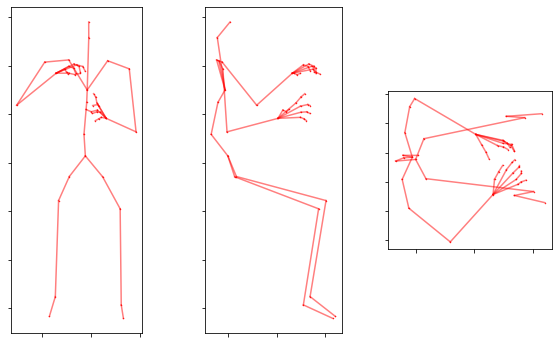

In [ ]:
# spl gaitplotlib
import matplotlib.pyplot as plt
params = gpl.plottable(_poses.numpy())

def _plot_pose(pose_index, save_to=None):
    fig, axes = plt.subplots(1, 3, figsize=(10,6))

    for d, ax in enumerate(axes):
        dims_to_plot = [i for i in range(3) if i != d]
        joints, skeleton = params[pose_index]["joints"], params.skeleton
        j = joints[:, dims_to_plot]
        ax.scatter(*j.T, color="r", s=0.2)
        for bone in skeleton:
            a = j[bone[0]]
            b = j[bone[1]]
            x, y = list(zip(a, b))
            ax.plot(x, y, color="r", alpha=0.5)
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.set_aspect('equal', adjustable='box')
    if save_to is not None:
        plt.tight_layout()
        plt.savefig(save_to)
        plt.close()
    else:
        plt.show()

_plot_pose(0)

""

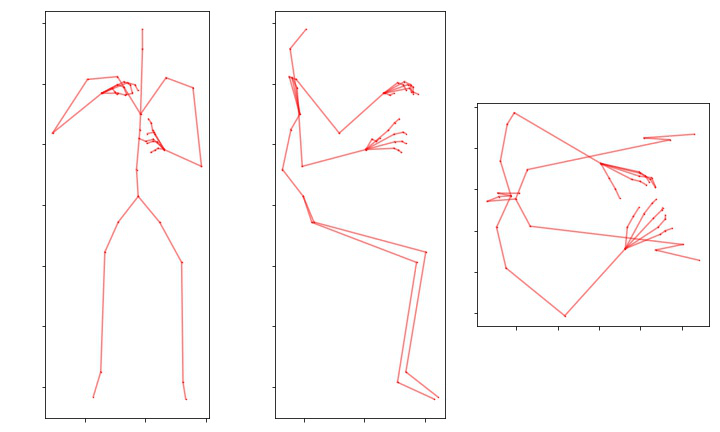

In [ ]:
# spl gaitplotlib
from pathlib import Path
import mediapy as media

n_frames = 10

with tempfile.TemporaryDirectory() as tmpdirname:
    animloc = Path(tmpdirname)/'anim'
    animloc.mkdir(exist_ok=True)

    def get_frame(i, frameloc=animloc/'frame.jpeg'):
        _plot_pose(i, save_to=frameloc)
        return media.read_image(frameloc)    
    img_arr = get_frame(0)

    fps = 10

    with media.VideoWriter(animloc/'anim.gif', codec='gif', shape=img_arr.shape[:2], fps=fps) as w:
        for i in range(0, fps*n_frames, 10):
            frameloc = animloc/'frame.jpeg'
            _plot_pose(i, save_to=frameloc)
            img_arr = media.read_image(frameloc)
            w.add_image(img_arr)
            
    video = media.read_video(animloc/'anim.gif')
    media.show_video(video, codec='gif')

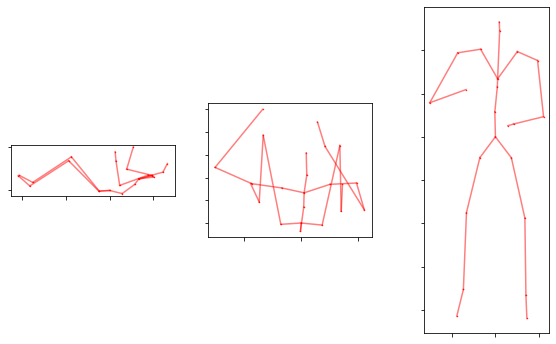

In [ ]:
# spl gaitplotlib
import matplotlib.pyplot as plt

skeleton = smplh['kintree_table'].T[1:]

def plot_pose(positions, skeleton, save_to=None):
    fig, axes = plt.subplots(1, 3, figsize=(10,6))

    for d, ax in enumerate(axes):
        dims_to_plot = [i for i in range(3) if i != d]
        joints = positions
        j = joints[:, dims_to_plot]
        ax.scatter(*j.T, color="r", s=0.2)
        for bone in skeleton:
            if set(bone) <= set(range(positions.shape[0])):
                a = j[bone[0]]
                b = j[bone[1]]
                x, y = list(zip(a, b))
                ax.plot(x, y, color="r", alpha=0.5)
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.set_aspect('equal', adjustable='box')
    if save_to is not None:
        plt.tight_layout()
        plt.savefig(save_to)
        plt.close()
    else:
        plt.show()

plot_pose(positions[0,:-1], skeleton)

""

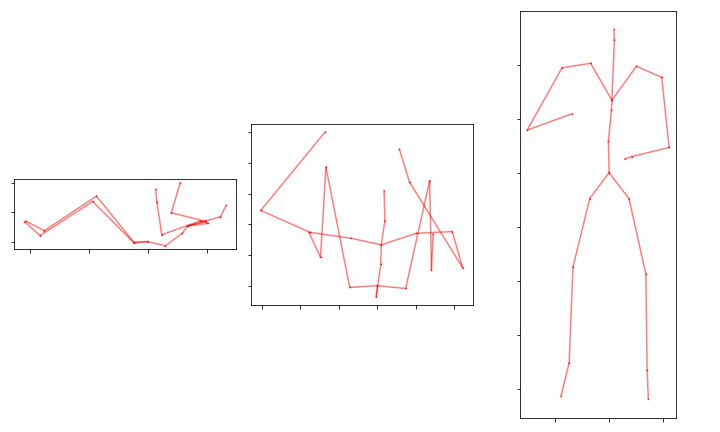

In [ ]:
# spl gaitplotlib
from pathlib import Path
import mediapy as media

n_frames = 10

with tempfile.TemporaryDirectory() as tmpdirname:
    animloc = Path(tmpdirname)/'anim'
    animloc.mkdir(exist_ok=True)

    def get_frame(i, frameloc=animloc/'frame.jpeg'):
        plot_pose(positions[i][:-1], skeleton, save_to=frameloc)
        return media.read_image(frameloc)    
    img_arr = get_frame(0)

    fps = 10

    with media.VideoWriter(animloc/'anim.gif', codec='gif', shape=img_arr.shape[:2], fps=fps) as w:
        for i in range(0, fps*n_frames, 10):
            frameloc = animloc/'frame.jpeg'
            plot_pose(positions[i][:-1], skeleton, save_to=frameloc)
            img_arr = media.read_image(frameloc)
            w.add_image(img_arr)
            
    video = media.read_video(animloc/'anim.gif')
    media.show_video(video, codec='gif')

## ForwardKinematics Module

> The same forward kinematics functionality, implemented as a torch Module.

In [ ]:
# exports
"""
PyTorch port of forward kinematics engine from:
SPL: training and evaluation of neural networks with a structured prediction layer.
Copyright (C) 2021 ETH Zurich, Emre Aksan, Manuel Kaufmann, Gavin Gray

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.
"""

import torch.nn as nn

class ForwardKinematics(nn.Module):
    def __init__(self, offsets, parents, left_mult=False, major_joints=None, norm_idx=None, no_root=True):
        super(ForwardKinematics, self).__init__()
        self.register_buffer('offsets', offsets)
        if norm_idx is not None:
            self.offsets = self.offsets / np.linalg.norm(self.offsets[norm_idx])
        self.parents = parents
        self.n_joints = len(parents)
        self.major_joints = major_joints
        self.left_mult = left_mult
        self.no_root = no_root
        assert self.offsets.shape[0] == self.n_joints
        
    def fk(self, joint_angles):
        """
        Perform forward kinematics. This requires joint angles to be in rotation matrix format.
        Args:
            joint_angles: torch tensor of shape (N, n_joints*3*3)
        Returns:
            The 3D joint positions as a tensor of shape (N, n_joints, 3)
        """
        assert joint_angles.shape[-1] == self.n_joints * 9
        angles = joint_angles.view(-1, self.n_joints, 3, 3)
        n_frames = angles.size(0)
        device = angles.device
        if self.left_mult:
            offsets = self.offsets.view(1, 1, self.n_joints, 3)
        else:
            offsets = self.offsets.view(1, self.n_joints, 3, 1)

        if self.no_root:
            angles[:, 0] = torch.eye(3).to(device)

        assert self.parents[0] == -1
        positions = {0: torch.zeros([n_frames, 3]).to(device)}
        rotations = {0: angles[:, 0]}

        for j in range(1, self.n_joints):
            prev_rotation = rotations[self.parents[j]]
            prev_position = positions[self.parents[j]]
            # this is a regular joint
            if self.left_mult:
                position = torch.squeeze(torch.matmul(offsets[:, :, j], prev_rotation)) + prev_position
                rotation = torch.matmul(angles[:, j], prev_rotation)
            else:
                position = torch.squeeze(torch.matmul(prev_rotation, offsets[:, j])) + prev_position
                rotation =  torch.matmul(prev_rotation, angles[:, j])
            positions[j] = position
            rotations[j] = rotation
                
        return torch.cat([positions[j].view(n_frames, 1, 3) for j in range(self.n_joints)], 1)
    
    def from_aa(self, joint_angles):
        """
        Get joint positions from angle axis representations in shape (N, n_joints*3).
        """
        angles_rot = Rotation.from_rotvec(joint_angles).as_matrix()
        return self.fk(torch.reshape(angles_rot, [-1, self.n_joints * 9]))
    
    def from_rotmat(self, joint_angles):
        """
        Get joint positions from rotation matrix representations in shape (N, n_joints*3*3).
        """
        return self.fk(joint_angles)
    
    def from_quat(self, joint_angles):
        raise NotImplementedError()

    def from_sparse(self, joint_angles_sparse, rep="rotmat", return_sparse=True):
        raise NotImplementedError()

In [ ]:
# exports
SMPLH_PARENTS = [-1, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 12, 13, 14, 16, 17, 18, 19, 20, 22]
SMPLH_MAJOR_JOINTS = [1, 2, 3, 4, 5, 6, 9, 12, 13, 14, 15, 16, 17, 18, 19]
SMPLH_SKELETON = np.array([[ 0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9,  9, 12, 13,
        14, 16, 17, 18, 19, 20, 22, 23, 20, 25, 26, 20, 28, 29, 20, 31,
        32, 20, 34, 35, 21, 37, 38, 21, 40, 41, 21, 43, 44, 21, 46, 47,
        21, 49, 50],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51]]).T

class SMPLHForwardKinematics(ForwardKinematics):
    """
    Forward Kinematics for the skeleton defined by SMPL-H.
    """
    def __init__(self):
        # this are the offsets stored under `J` in the SMPL model pickle file
        offsets = torch.tensor([[-1.79505953e-03, -2.23333446e-01,  2.82191255e-02],
                           [ 6.77246757e-02, -3.14739671e-01,  2.14037877e-02],
                           [-6.94655406e-02, -3.13855126e-01,  2.38993038e-02],
                           [-4.32792313e-03, -1.14370215e-01,  1.52281192e-03],
                           [ 1.02001221e-01, -6.89938274e-01,  1.69079858e-02],
                           [-1.07755594e-01, -6.96424140e-01,  1.50492738e-02],
                           [ 1.15910534e-03,  2.08102144e-02,  2.61528404e-03],
                           [ 8.84055199e-02, -1.08789863e+00, -2.67853442e-02],
                           [-9.19818258e-02, -1.09483879e+00, -2.72625243e-02],
                           [ 2.61610388e-03,  7.37324481e-02,  2.80398521e-02],
                           [ 1.14763659e-01, -1.14368952e+00,  9.25030544e-02],
                           [-1.17353574e-01, -1.14298274e+00,  9.60854266e-02],
                           [-1.62284535e-04,  2.87602804e-01, -1.48171829e-02],
                           [ 8.14608431e-02,  1.95481750e-01, -6.04975478e-03],
                           [-7.91430834e-02,  1.92565283e-01, -1.05754332e-02],
                           [ 4.98955543e-03,  3.52572414e-01,  3.65317875e-02],
                           [ 1.72437770e-01,  2.25950646e-01, -1.49179062e-02],
                           [-1.75155461e-01,  2.25116450e-01, -1.97185045e-02],
                           [ 4.32050017e-01,  2.13178586e-01, -4.23743412e-02],
                           [-4.28897421e-01,  2.11787231e-01, -4.11194829e-02],
                           [ 6.81283645e-01,  2.22164620e-01, -4.35452575e-02],
                           [-6.84195501e-01,  2.19559526e-01, -4.66786778e-02],
                           [ 7.65325829e-01,  2.14003084e-01, -5.84906248e-02],
                           [-7.68817426e-01,  2.13442268e-01, -5.69937621e-02]])

        # need to convert them to compatible offsets
        smplh_offsets = torch.zeros([24, 3])
        smplh_offsets[0] = offsets[0]
        for idx, pid in enumerate(SMPLH_PARENTS[1:]):
            smplh_offsets[idx+1] = offsets[idx + 1] - offsets[pid]

        # normalize so that right thigh has length 1
        super(SMPLHForwardKinematics, self).__init__(smplh_offsets, SMPLH_PARENTS, norm_idx=4,
                                                    left_mult=False, major_joints=SMPLH_MAJOR_JOINTS)

In [ ]:
# spl
torch.autograd.set_detect_anomaly(True)

fk_engine = SMPLHForwardKinematics()
_fk_engine = _SMPLH_ForwardKinematics()

with tempfile.TemporaryDirectory() as tmpdirname:
    unpack_body_models("sample_data/", tmpdirname, 1, verify=False)
    for npz_path in npz_paths(tmpdirname):
        cdata = np.load(npz_path)
        _poses = torch.tensor(cdata['poses'][:, :24*3], requires_grad=True, dtype=torch.float)
        poses = _poses
        n, d = poses.size()
        j = d//3
        _positions = _fk_engine.from_aa(poses.detach().numpy())
        positions = fk_engine.from_aa(poses)
        err = np.abs(_positions - positions.detach().numpy())
        positions.sum().backward()
        assert torch.abs(_poses.grad).max() > 1e-3
        assert err.max() < 1e-4, f"{err.max()}"

  0%|          | 0/1 [00:00<?, ?it/s]

# Scipy Transforms

> Transforms to use during data loading on numpy arrays using `scipy.spatial.transforms`.

In [ ]:
# exports
import math

def scipy_aa_to_euler(x, seq='zyx'):
    s = x.shape
    x = x.reshape(-1, 3)
    euler = R.from_rotvec(x).as_euler(seq)
    return euler.reshape(*s)

def scipy_euler_to_aa(x, seq='zyx'):
    s = x.shape
    x = x.reshape(-1, 3)
    aa = R.from_euler(seq, x).as_rotvec()
    return aa.reshape(*s)

In [ ]:
# spl
with tempfile.TemporaryDirectory() as tmpdirname:
    unpack_body_models("sample_data/", tmpdirname, 1, verify=False)
    for npz_path in npz_paths(tmpdirname):
        cdata = np.load(npz_path)
        aa = cdata['poses'][:, :24*3]
        euler = scipy_aa_to_euler(aa)
        _aa = scipy_euler_to_aa(euler)
        assert np.allclose(aa, _aa)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# hide
from nbdev.export import notebook2script

notebook2script()

Converted 00_core.ipynb.
Converted 01_tqdm.ipynb.
Converted 02_features.ipynb.
Converted 03_transforms.ipynb.
Converted 05_losses.ipynb.
Converted index.ipynb.
